In [ ]:
import os
import yaml
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plateconfig import PlateConfig


general_data_dir = "../data"
all_dirs = ["07182025_IF_scan"]
config_dict = {}
if_data_file = "Cell.csv"

for data_dir in all_dirs:
	config_fname = f"{general_data_dir}/{data_dir}/plate_config.yaml"
	if os.path.exists(config_fname):
		plate_obj = PlateConfig(config_fname)
		config_dict[data_dir] = plate_obj
	else:
		print(f"Config file does not exist.")


Successfully loaded ../data/07182025_IF_scan/plate_config.yaml


In [ ]:
dfs = []
for dir in all_dirs:
	full_fname = f"{general_data_dir}/{dir}/{if_data_file}"
	columns = ["WellId", "CircTotalIntenCh2", "CircTotalIntenCh3"]
	df = pd.read_csv(full_fname, usecols=columns)
	df["WellId"] = [x.strip() for x in df["WellId"]] # remove leading/trailing spaces in WellIds

	# get the corresponding configuration dictionary
	plate_config = config_dict[dir]
	plate_config.rows = plate_config.row_to_patient.keys()
 
	columns = list(plate_config.column_to_stain.keys())
	# Combine control wells (i.e., B1 and B2) into a single WellId
	if plate_config.double_control_wells:
		control_column_tuples = [(1,2),(7,8)]
		control_well_dict = {}
		for tup in control_column_tuples:
			for row in plate_config.row_to_patient.keys():
				well_id1 = f"{row}{tup[0]:02d}"
				well_id2 = f"{row}{tup[1]:02d}"
				df = df.replace(well_id2, well_id1)
		columns.remove(2)
		columns.remove(8)
	plate_config.control_columns = [1, 7]
	plate_config.test_columns = [np.r_[3:7], np.r_[9:13]]
	plate_config.columns = columns
 
	# store row and columns for each well id as individual columns
	df["Row"] = [x[0] for x in df["WellId"]]
	df["Column"] = [x[1:] for x in df["WellId"]]
	plate_config.set_plate_data(df)
	display(df)

,WellId,CircTotalIntenCh2,CircTotalIntenCh3,Row,Column
0,B01,1928539,644046,B,01
1,B01,1344189,376605,B,01
2,B01,1626749,357199,B,01
3,B01,2920563,953703,B,01
4,B01,2137419,1189482,B,01
...,...,...,...,...,...
58918,E12,662498,180994,E,12
58919,E12,1755947,319289,E,12
58920,E12,2167799,387586,E,12
58921,E12,1840855,279931,E,12


In [60]:
def calc_l2fc(plate, lfc_df):
	stat1_lfcs = []
	stat3_lfcs = []
	for row in lfc_df["Row"].unique():
		cur_df = lfc_df[lfc_df["Row"] == row]
		for i, control_col in enumerate(plate.control_columns):
			control_data = cur_df[cur_df["Column"] == control_col]
			test_cols = cur_df[cur_df["Column"].isin([control_col, *plate.test_columns[i]])]
			#print(control_data)
			#print(cur_df["STAT1 log2 Median"])
			#print(control_data["STAT1 log2 Median"].values[0])
			new_stat1_l2fcs  = test_cols["STAT1 log2 Median"] - control_data["STAT1 log2 Median"].values[0]
			new_stat3_l2fcs  = test_cols["STAT3 log2 Median"] - control_data["STAT3 log2 Median"].values[0]
			#print(row, control_col, new_stat1_l2fcs)
			stat1_lfcs = stat1_lfcs + list(new_stat1_l2fcs)
			stat3_lfcs = stat3_lfcs + list(new_stat3_l2fcs)
			#print(stat1_lfcs)
			#return;
	lfc_df["STAT1 LFC"] = stat1_lfcs
	lfc_df["STAT3 LFC"] = stat3_lfcs
	return lfc_df
			

def find_pct_max(values):
	return np.divide(values, np.max(values))

for dir in all_dirs:
	plate = config_dict[dir]
	data = plate.data
	pct_max_dfs = []
	for row in data["Row"].unique():
		for i, control_col in enumerate(plate.control_columns):
			select_cols = [control_col, *plate.test_columns[i]]
			formatted_select_cols = [f"{x:02d}" for x in select_cols]
			select_data = data[(data["Row"] == row) & (data["Column"].isin(formatted_select_cols))].copy()
			select_data["STAT1"] = find_pct_max(select_data["CircTotalIntenCh2"])
			select_data["STAT3"] = find_pct_max(select_data["CircTotalIntenCh3"])
			pct_max_dfs.append(select_data)
   
	pct_max_df = pd.concat(pct_max_dfs, ignore_index=True)
	#display(pct_max_df)
	stat1_means = pct_max_df.groupby("WellId")["STAT1"].mean()
	stat1_stds = pct_max_df.groupby("WellId")["STAT1"].std()
	stat3_means = pct_max_df.groupby("WellId")["STAT3"].mean()
	stat3_stds = pct_max_df.groupby("WellId")["STAT3"].std()

	stat_df = pd.concat([stat1_means, stat1_stds, stat3_means, stat3_stds], axis=1)
	stat_df.columns = ["STAT1 Mean", "STAT1 STD", "STAT3 Mean", "STAT3 STD"]

	rows = [x.strip()[0] for x in stat_df.index.values]
	cols = [int(x.strip()[1:]) for x in stat_df.index.values]
	stat_df["STAT"] = [plate.column_to_stain[int(x)] for x in cols]
	stat_df["Donor"] = [plate.row_to_patient[x] for x in rows]
	stat_df["IL-6 Concentration"] = ["10 ng/mL" for x in cols]
	stat_df["Time"] = [plate.column_to_t_pts[int(x)] for x in cols]
	stat_df["Replicate"] = [plate.row_to_replicate[x] for x in rows]
	plate_config.stat_df = stat_df
	#display(stat_df)
 
	# Create the log2 fold change dataframe
	stat1_lfc_med = pct_max_df.groupby("WellId")["CircTotalIntenCh2"].median().apply(np.log2)
	stat1_lfc_std = pct_max_df.groupby("WellId")["CircTotalIntenCh2"].std().apply(np.log2)
	stat3_lfc_med = pct_max_df.groupby("WellId")["CircTotalIntenCh3"].median().apply(np.log2)
	stat3_lfc_std = pct_max_df.groupby("WellId")["CircTotalIntenCh3"].std().apply(np.log2)
 
	stat_lfc_df = pd.concat([stat1_lfc_med, stat1_lfc_std, stat3_lfc_med, stat3_lfc_std], axis=1)
	stat_lfc_df.columns = ["STAT1 log2 Median", "STAT1 log2 STD", "STAT3 log2 Median", "STAT3 log2 STD"]
	rows = [x.strip()[0] for x in stat_lfc_df.index.values]
	cols = [int(x.strip()[1:]) for x in stat_lfc_df.index.values]
	stat_lfc_df["Row"] = rows
	stat_lfc_df["Column"] = cols
	stat_lfc_df["STAT"] = [plate.column_to_stain[int(x)] for x in cols]
	stat_lfc_df["Donor"] = [plate.row_to_patient[x] for x in rows]
	stat_lfc_df["IL-6 Concentration"] = ["10 ng/mL" for x in cols]
	stat_lfc_df["Time"] = [plate.column_to_t_pts[int(x)] for x in cols]
	stat_lfc_df["Replicate"] = [plate.row_to_replicate[x] for x in rows]
	#display(stat_lfc_df)
	
	processed_lfc_df = calc_l2fc(plate, stat_lfc_df)
	display(processed_lfc_df)
	plate_config.lfc_df = processed_lfc_df

,STAT1 log2 Median,STAT1 log2 STD,STAT3 log2 Median,STAT3 log2 STD,Row,Column,STAT,Donor,IL-6 Concentration,Time,Replicate,STAT1 LFC,STAT3 LFC
WellId,,,,,,,,,,,,,
B01,21.201204,20.156695,19.529688,17.848445,B,1,pSTAT,626,10 ng/mL,0,1,0.000000,0.000000
B03,22.007907,21.833086,22.344111,21.702522,B,3,pSTAT,626,10 ng/mL,20,1,0.806704,2.814423
B04,21.987273,21.222379,21.793782,20.910268,B,4,pSTAT,626,10 ng/mL,40,1,0.786069,2.264094
B05,21.437531,20.203646,20.506731,19.433060,B,5,pSTAT,626,10 ng/mL,60,1,0.236327,0.977043
B06,21.337448,19.472762,20.075738,18.403483,B,6,pSTAT,626,10 ng/mL,90,1,0.136244,0.546050
B07,22.759219,21.758990,22.304234,21.491416,B,7,tSTAT,626,10 ng/mL,0,1,0.000000,0.000000
B09,23.464529,22.396527,23.412236,22.232773,B,9,tSTAT,626,10 ng/mL,20,1,0.705310,1.108002
B10,23.861678,22.987553,22.992317,21.982066,B,10,tSTAT,626,10 ng/mL,40,1,1.102459,0.688083
B11,24.122589,23.394641,22.748917,22.702056,B,11,tSTAT,626,10 ng/mL,60,1,1.363370,0.444683


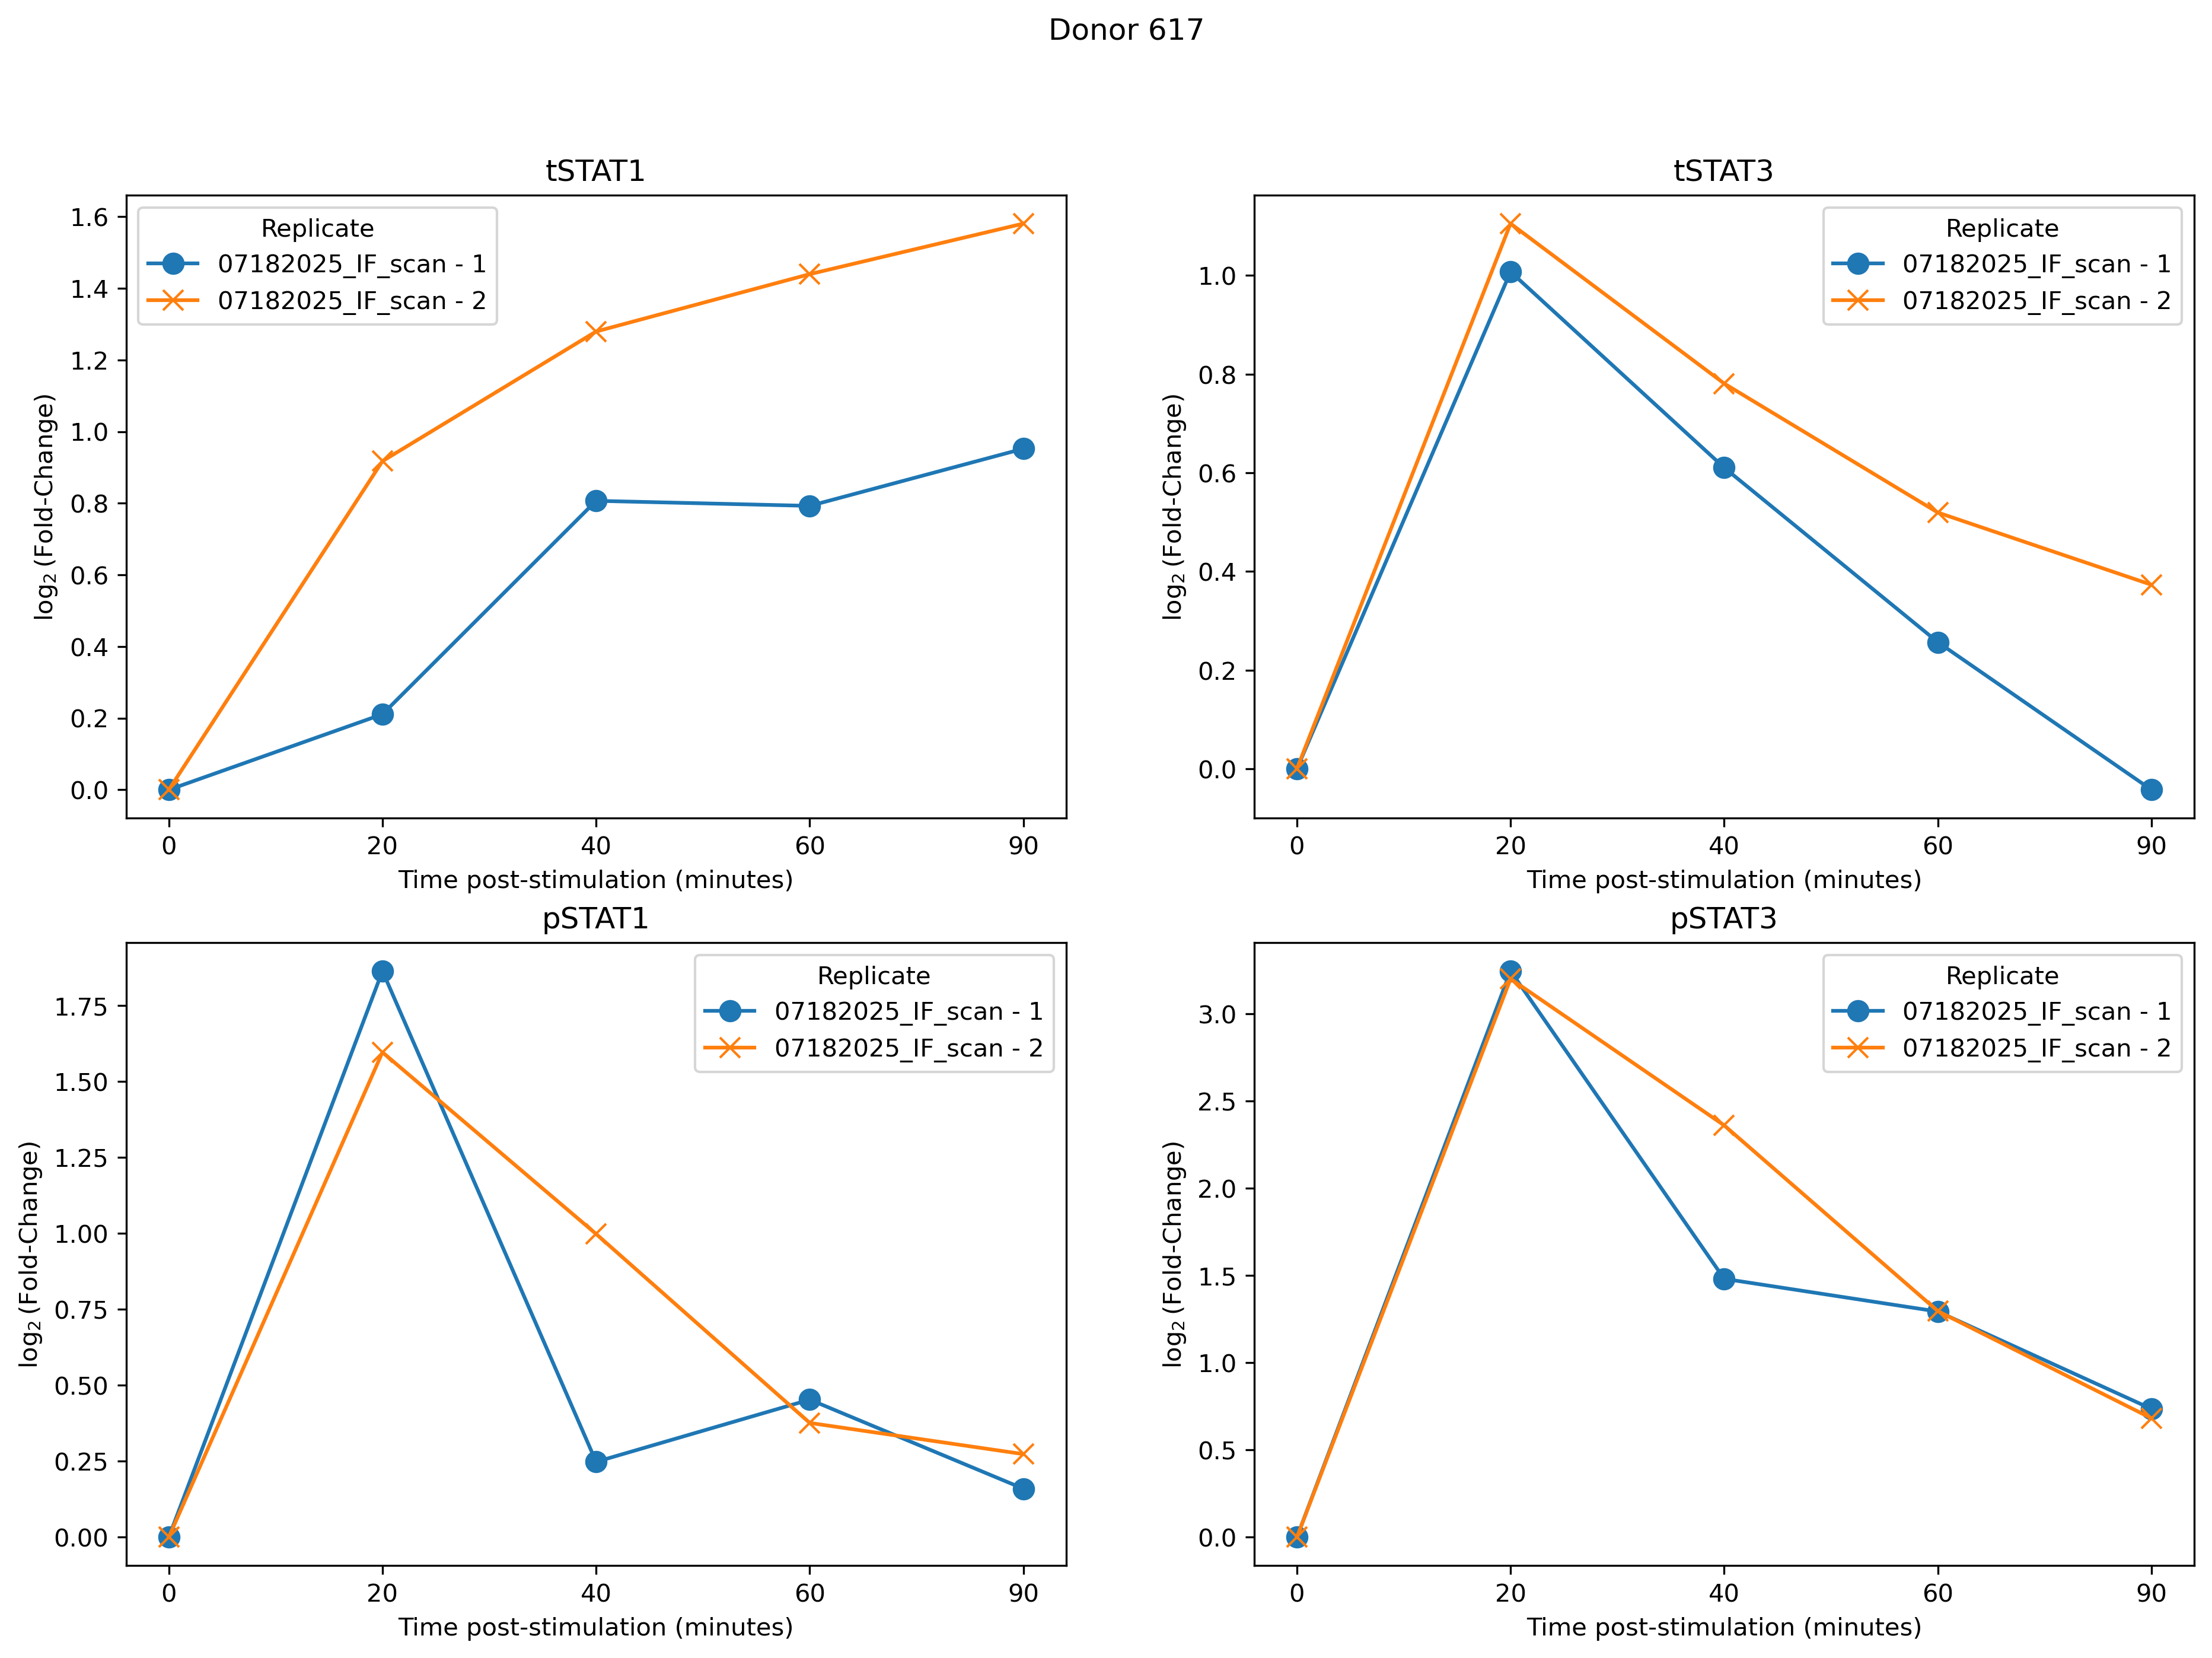

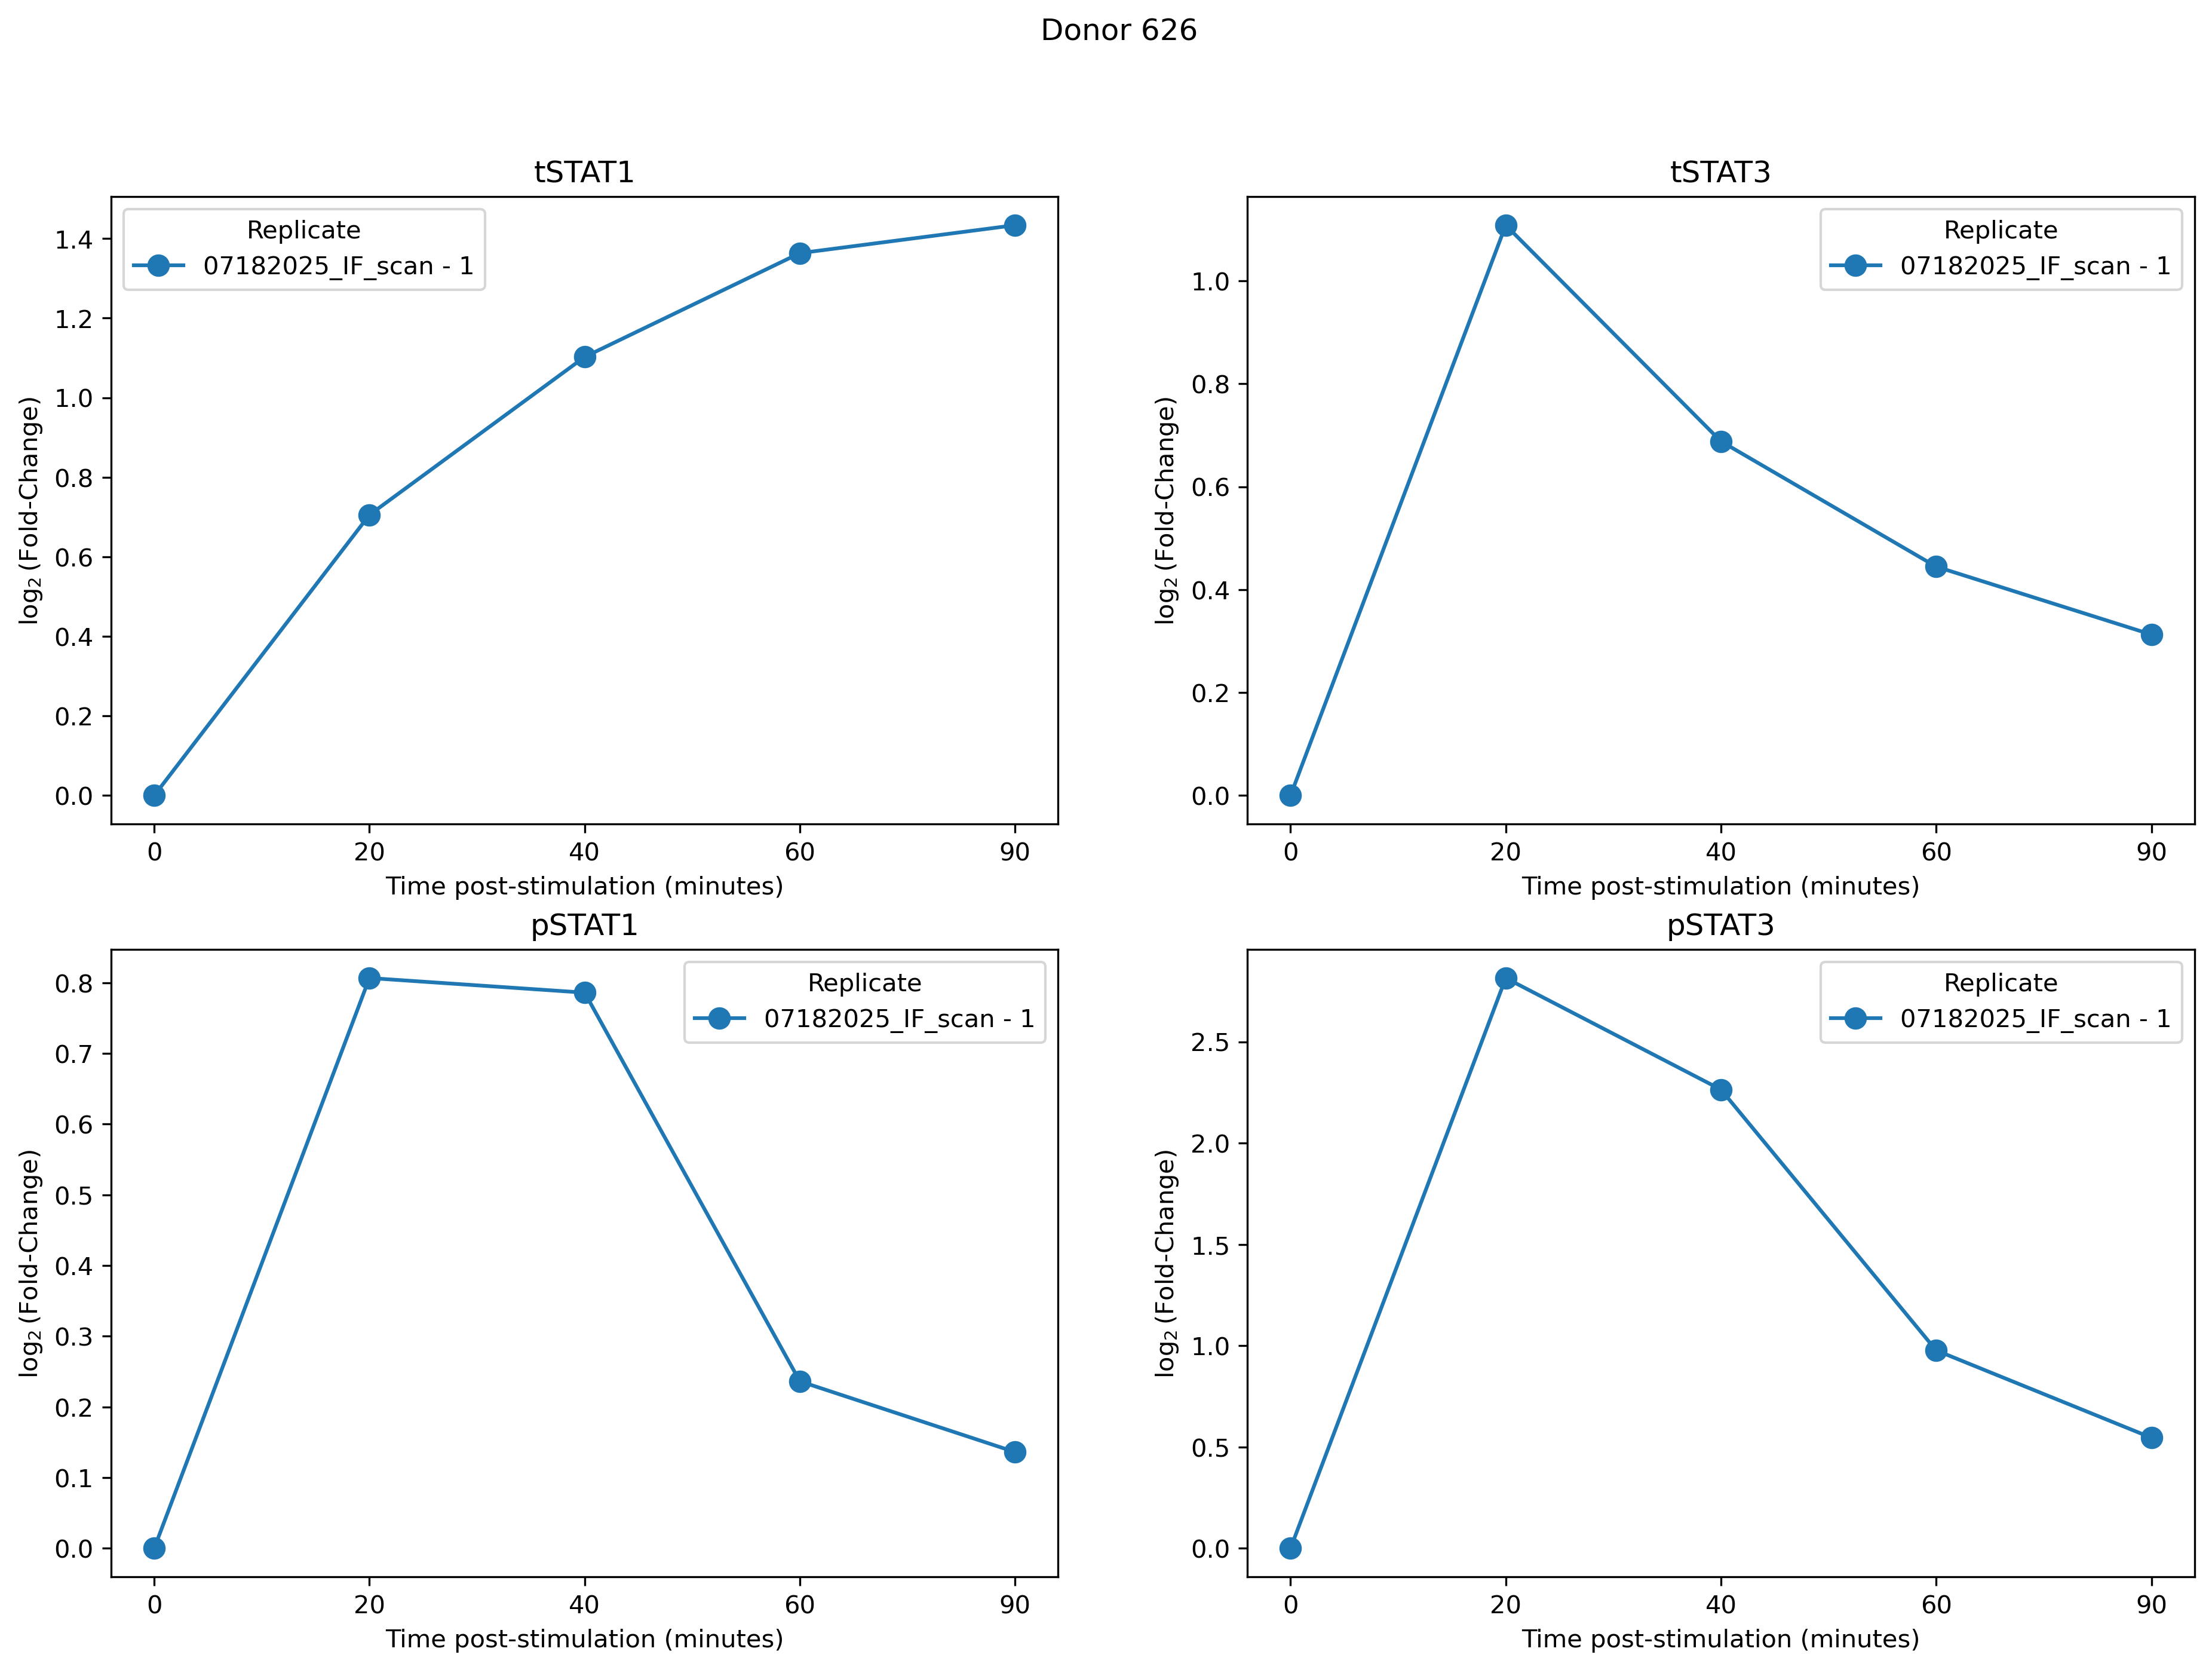

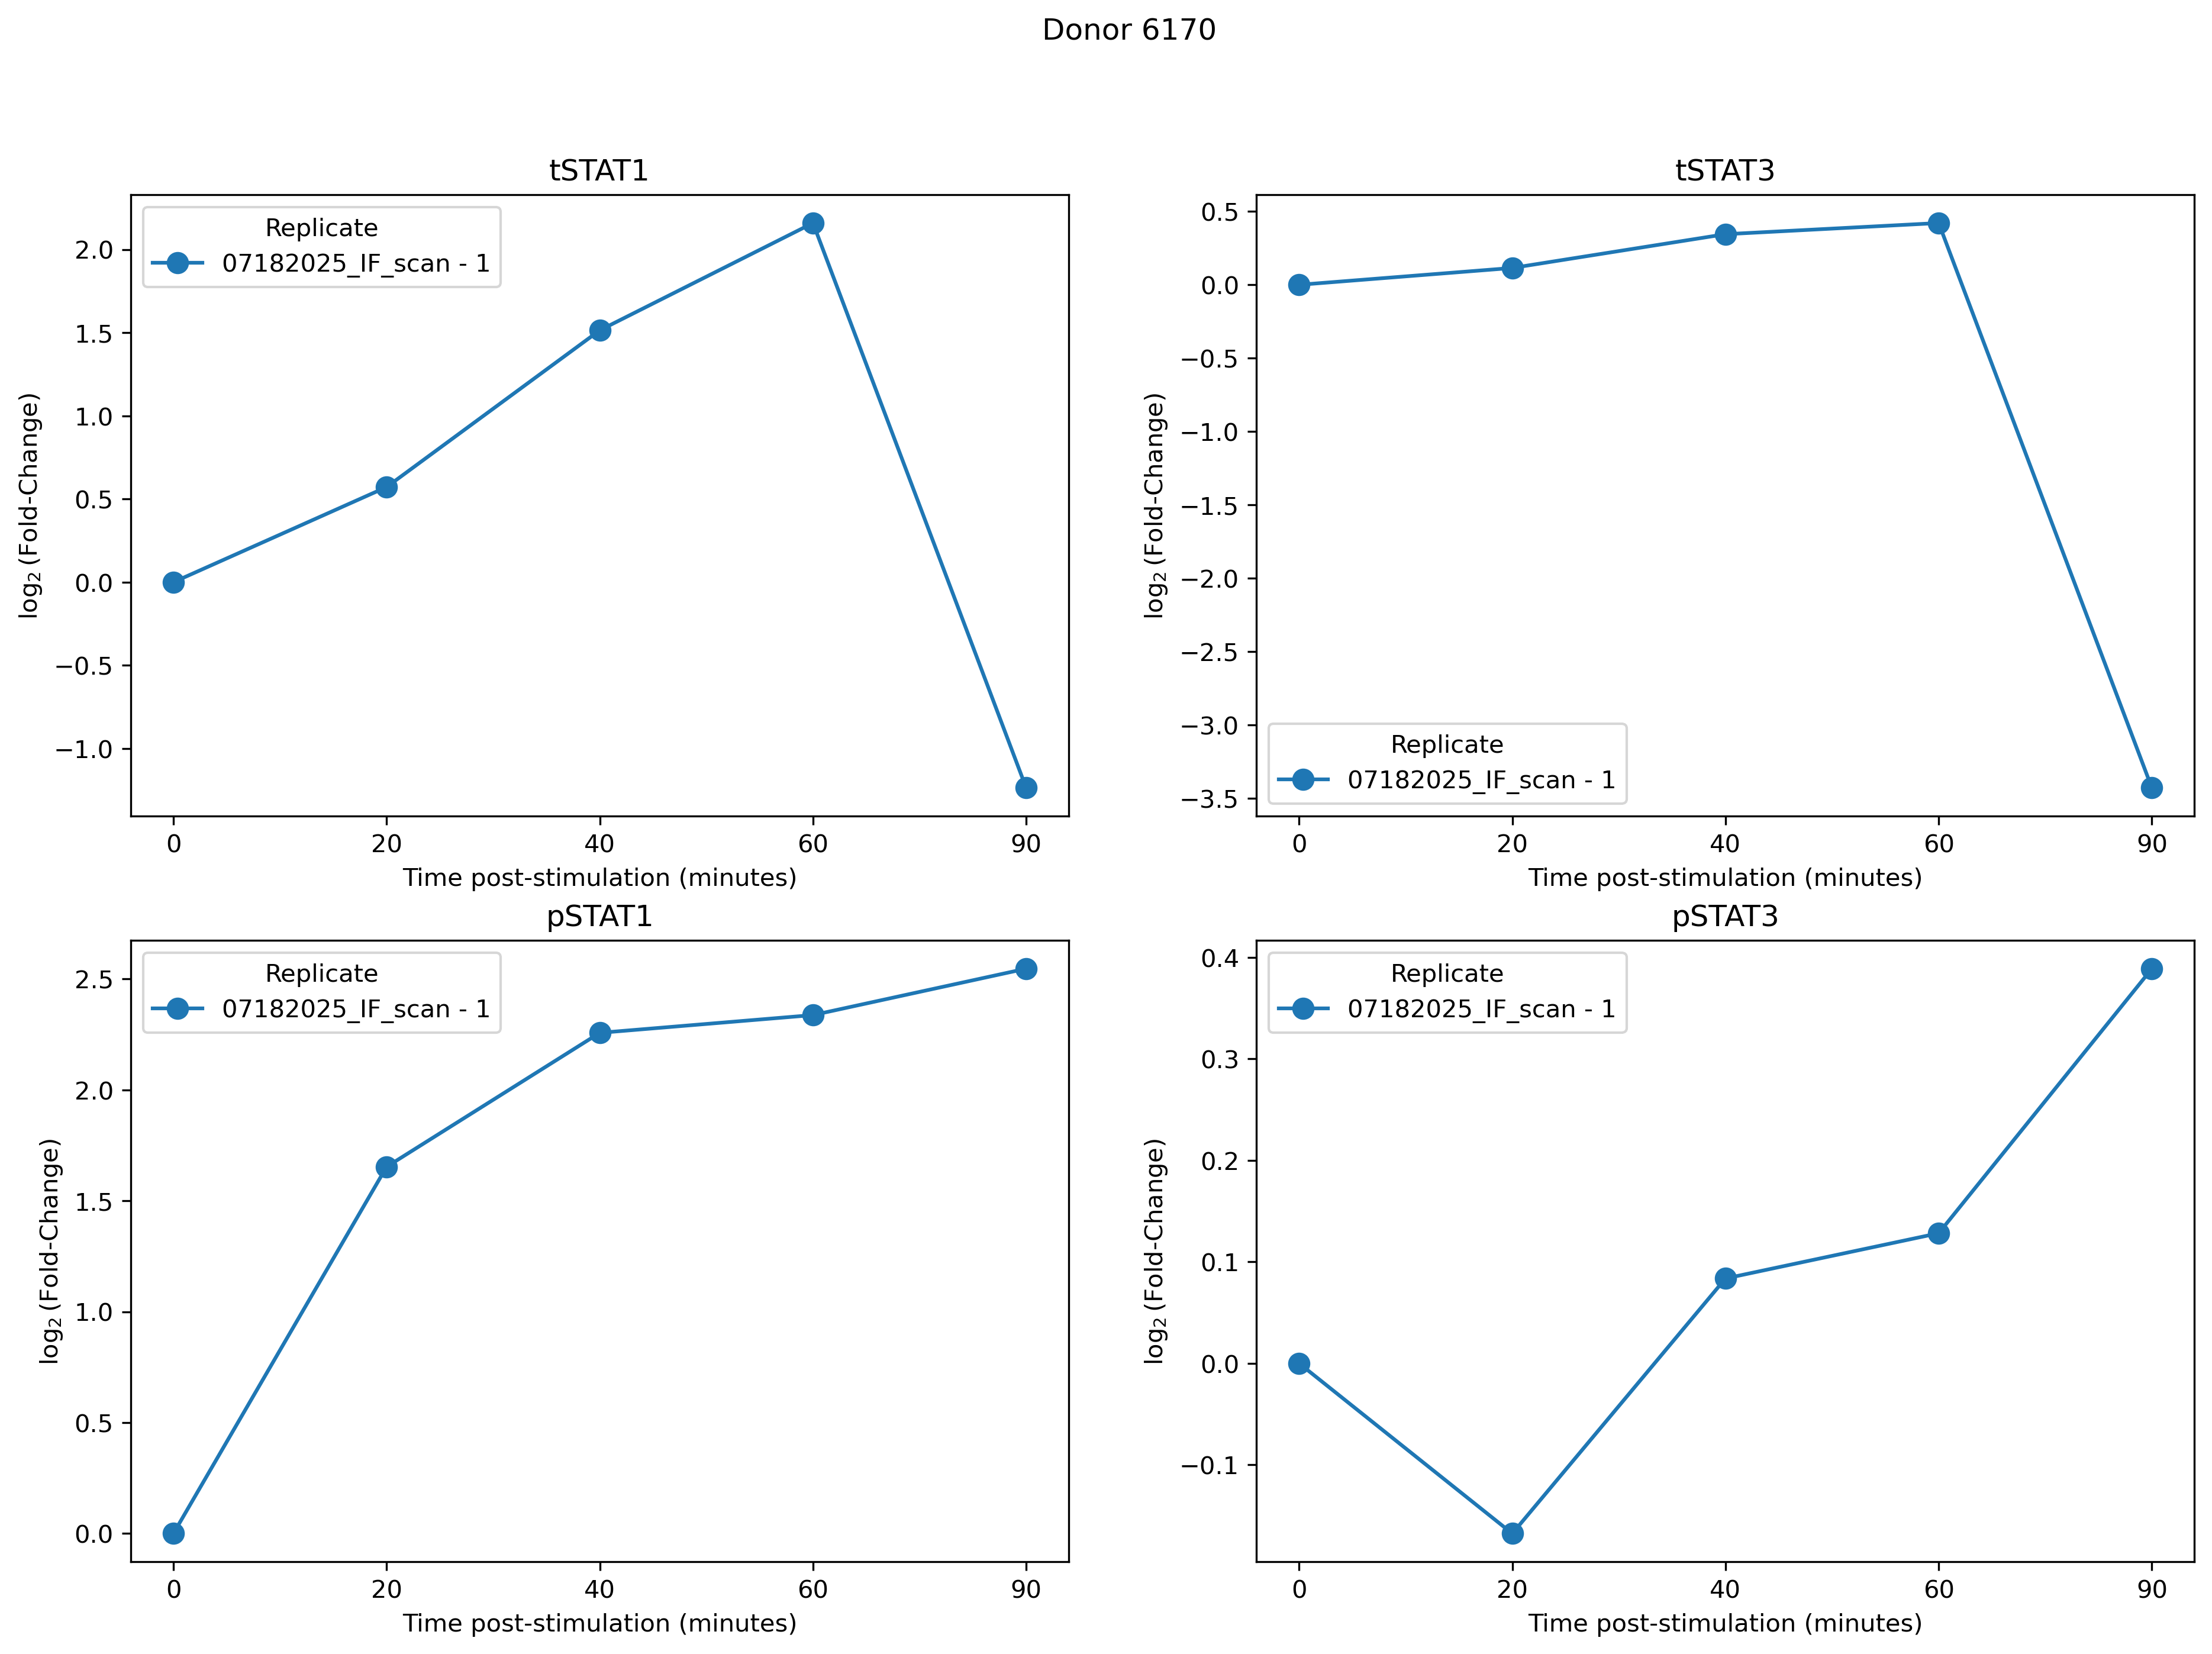

In [61]:
all_ids = np.unique(np.array([config_dict[dir].get_unique_patient_ids() for dir in all_dirs]).flatten())

id_to_fig = dict([id, plt.subplots(2,2, figsize=(15,10), dpi=300)] for id in all_ids);
ms = 8 # markersize

for id in all_ids:
	fig, ax = id_to_fig[id]
	fig.suptitle(f"Donor {id}")
	for dir in all_dirs:
		plate = config_dict[dir]
		
		# Get tSTAT data first 
		df = plate.lfc_df[(plate.lfc_df["Donor"] == id) & (plate.lfc_df["STAT"] == "tSTAT")] # TO DO: add case where included plate does NOT include specific donor
		
		stat1_ax = ax[0][0]
		stat3_ax = ax[0][1]
		for rep in df["Replicate"].unique():
			select_df = df.loc[df["Replicate"]== rep]
			stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 LFC"], #yerr=select_df["STAT1 log2 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
			
			stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 LFC"], #yerr=select_df["STAT3 log2 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
		stat1_ax.set_ylabel("$\log_2$(Fold-Change)")
		stat1_ax.set_xlabel("Time post-stimulation (minutes)")
		stat1_ax.legend(title="Replicate")
		stat1_ax.set_title("tSTAT1")
		stat3_ax.set_ylabel("$\log_2$(Fold-Change)")
		stat3_ax.set_xlabel("Time post-stimulation (minutes)")
		stat3_ax.legend(title="Replicate")
		stat3_ax.set_title("tSTAT3")
  
		# Get pSTAT data first 
		df = plate.lfc_df[(plate.lfc_df["Donor"] == id) & (plate.lfc_df["STAT"] == "pSTAT")] # TO DO: add case where included plate does NOT include specific donor
		
		stat1_ax = ax[1][0]
		stat3_ax = ax[1][1]
		for rep in df["Replicate"].unique():
			select_df = df.loc[df["Replicate"]== rep]
			stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 LFC"], #yerr=select_df["STAT1 log2 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
			
			stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 LFC"], #yerr=select_df["STAT3 log2 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
		stat1_ax.set_ylabel("$\log_2$(Fold-Change)")
		stat1_ax.set_xlabel("Time post-stimulation (minutes)")
		stat1_ax.legend(title="Replicate")
		stat1_ax.set_title("pSTAT1")
		stat3_ax.set_ylabel("$\log_2$(Fold-Change)")
		stat3_ax.set_xlabel("Time post-stimulation (minutes)")
		stat3_ax.legend(title="Replicate")
		stat3_ax.set_title("pSTAT3")

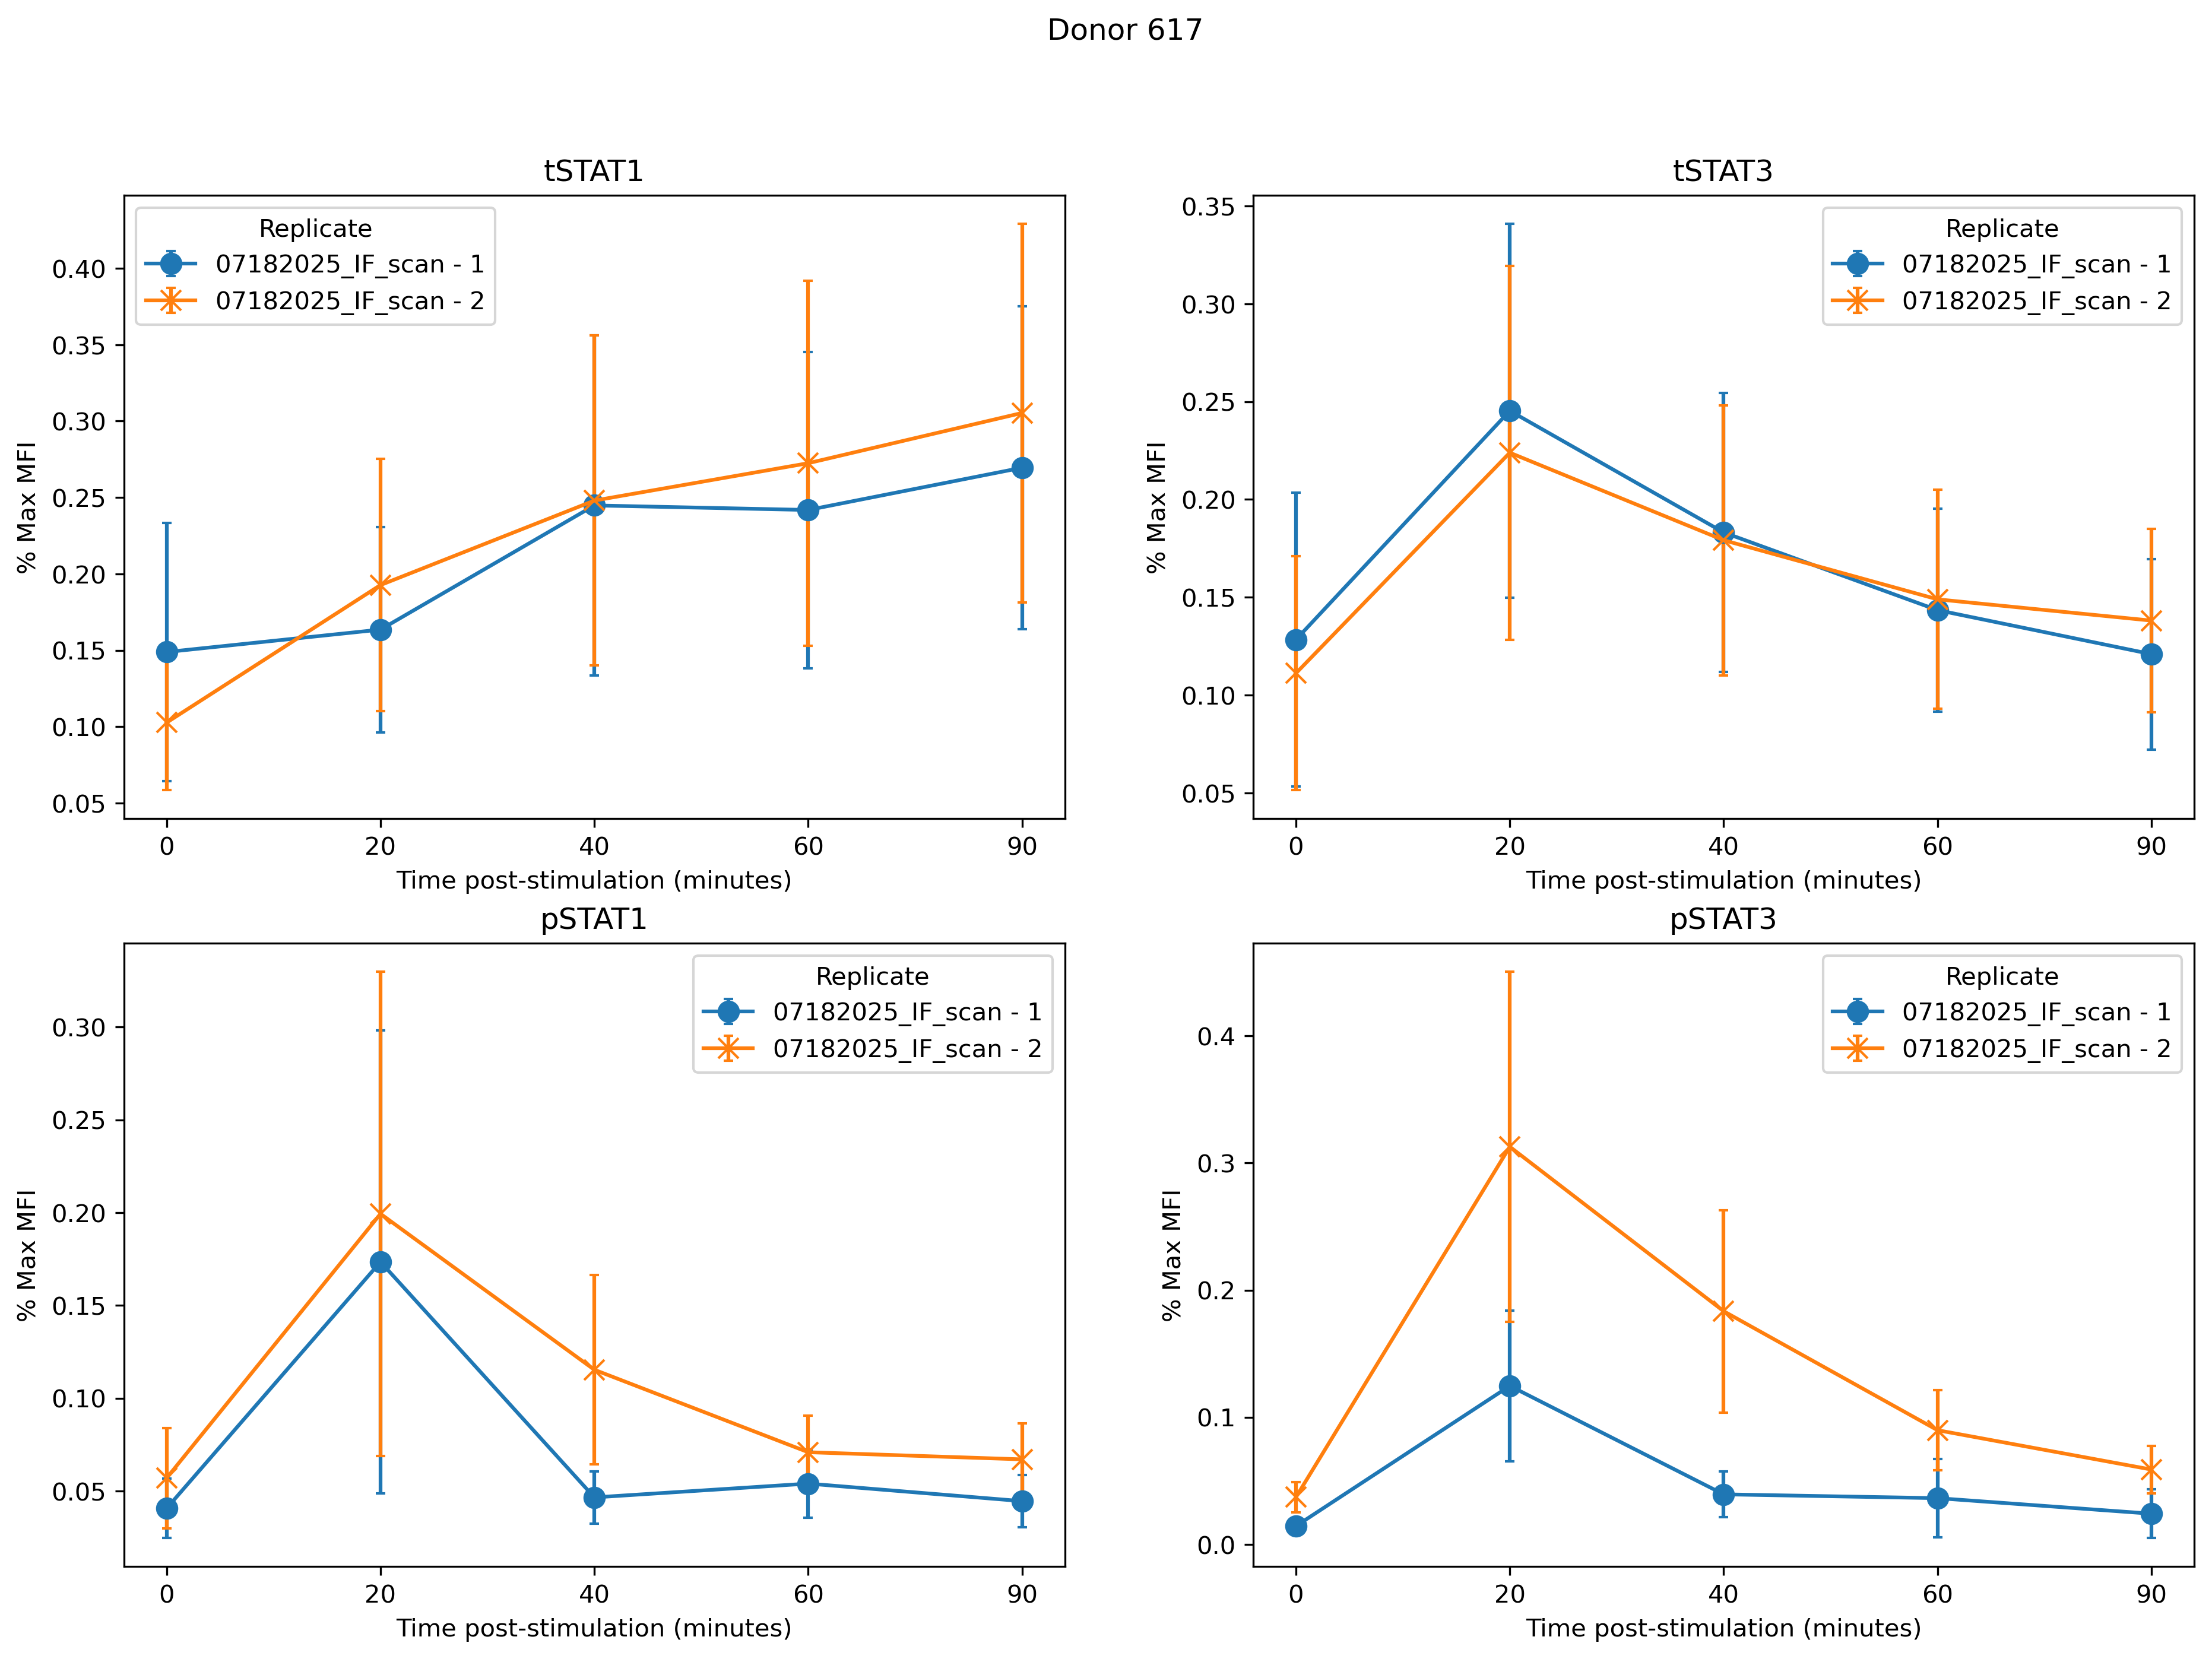

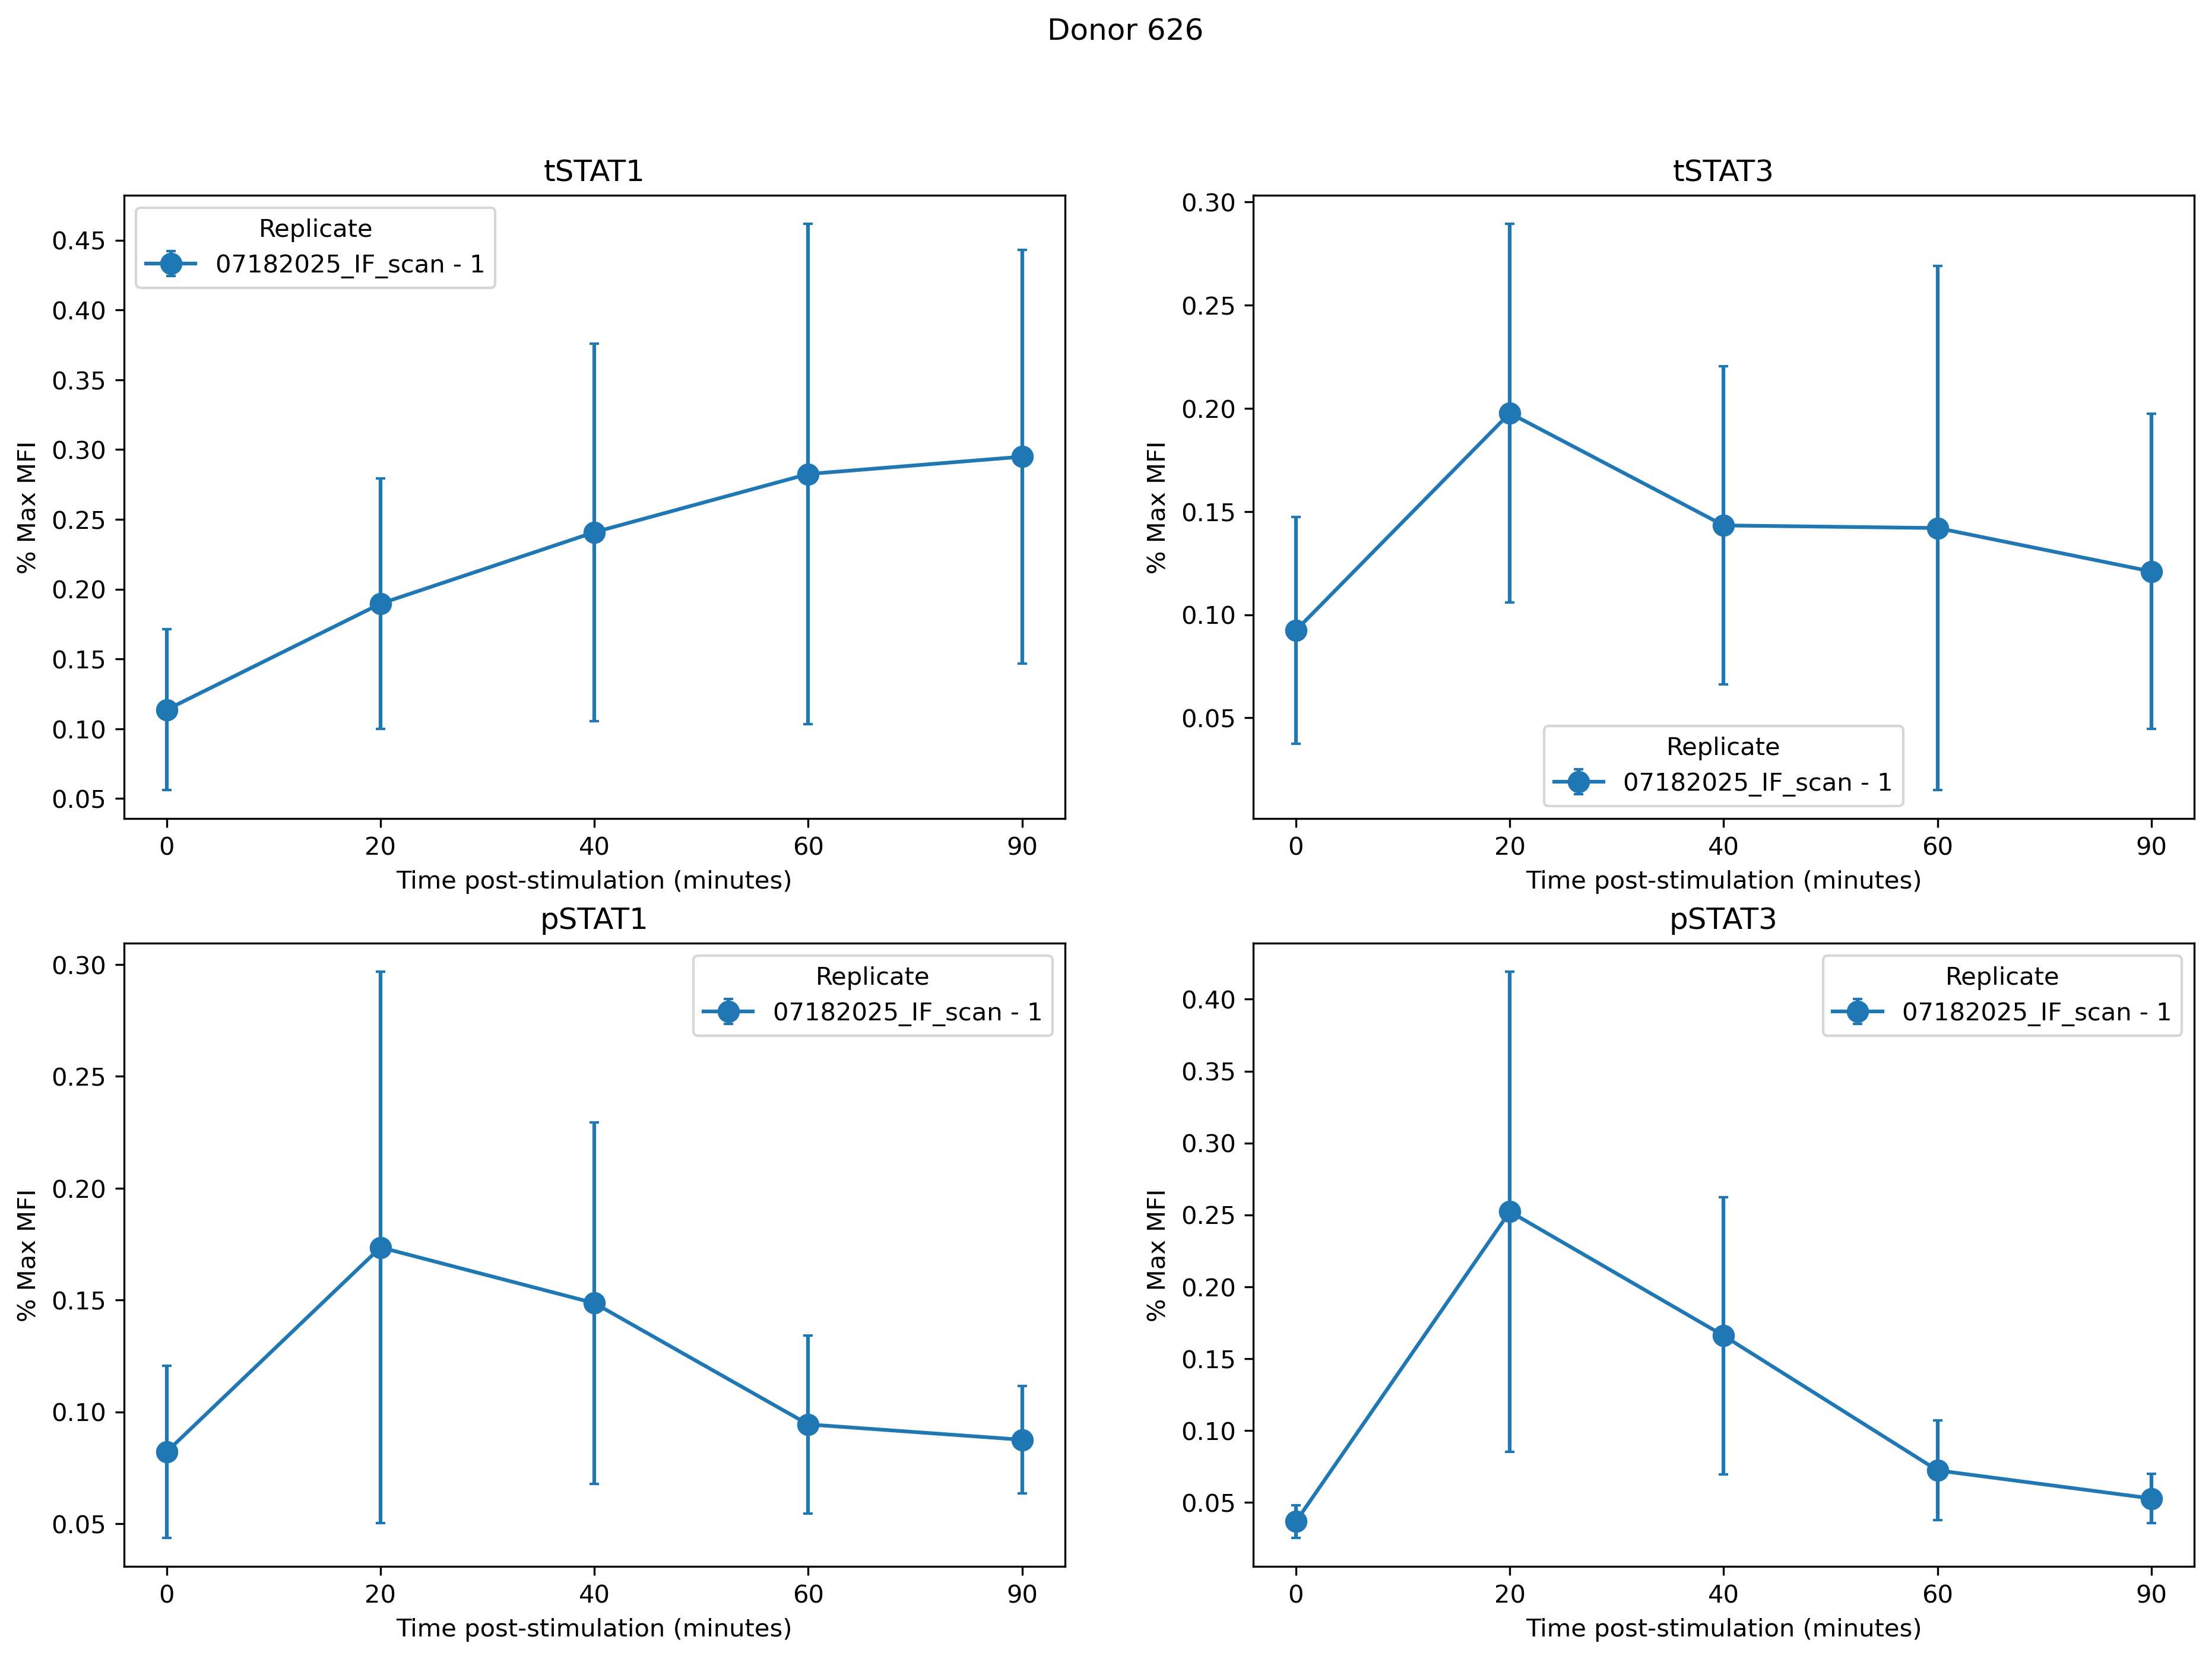

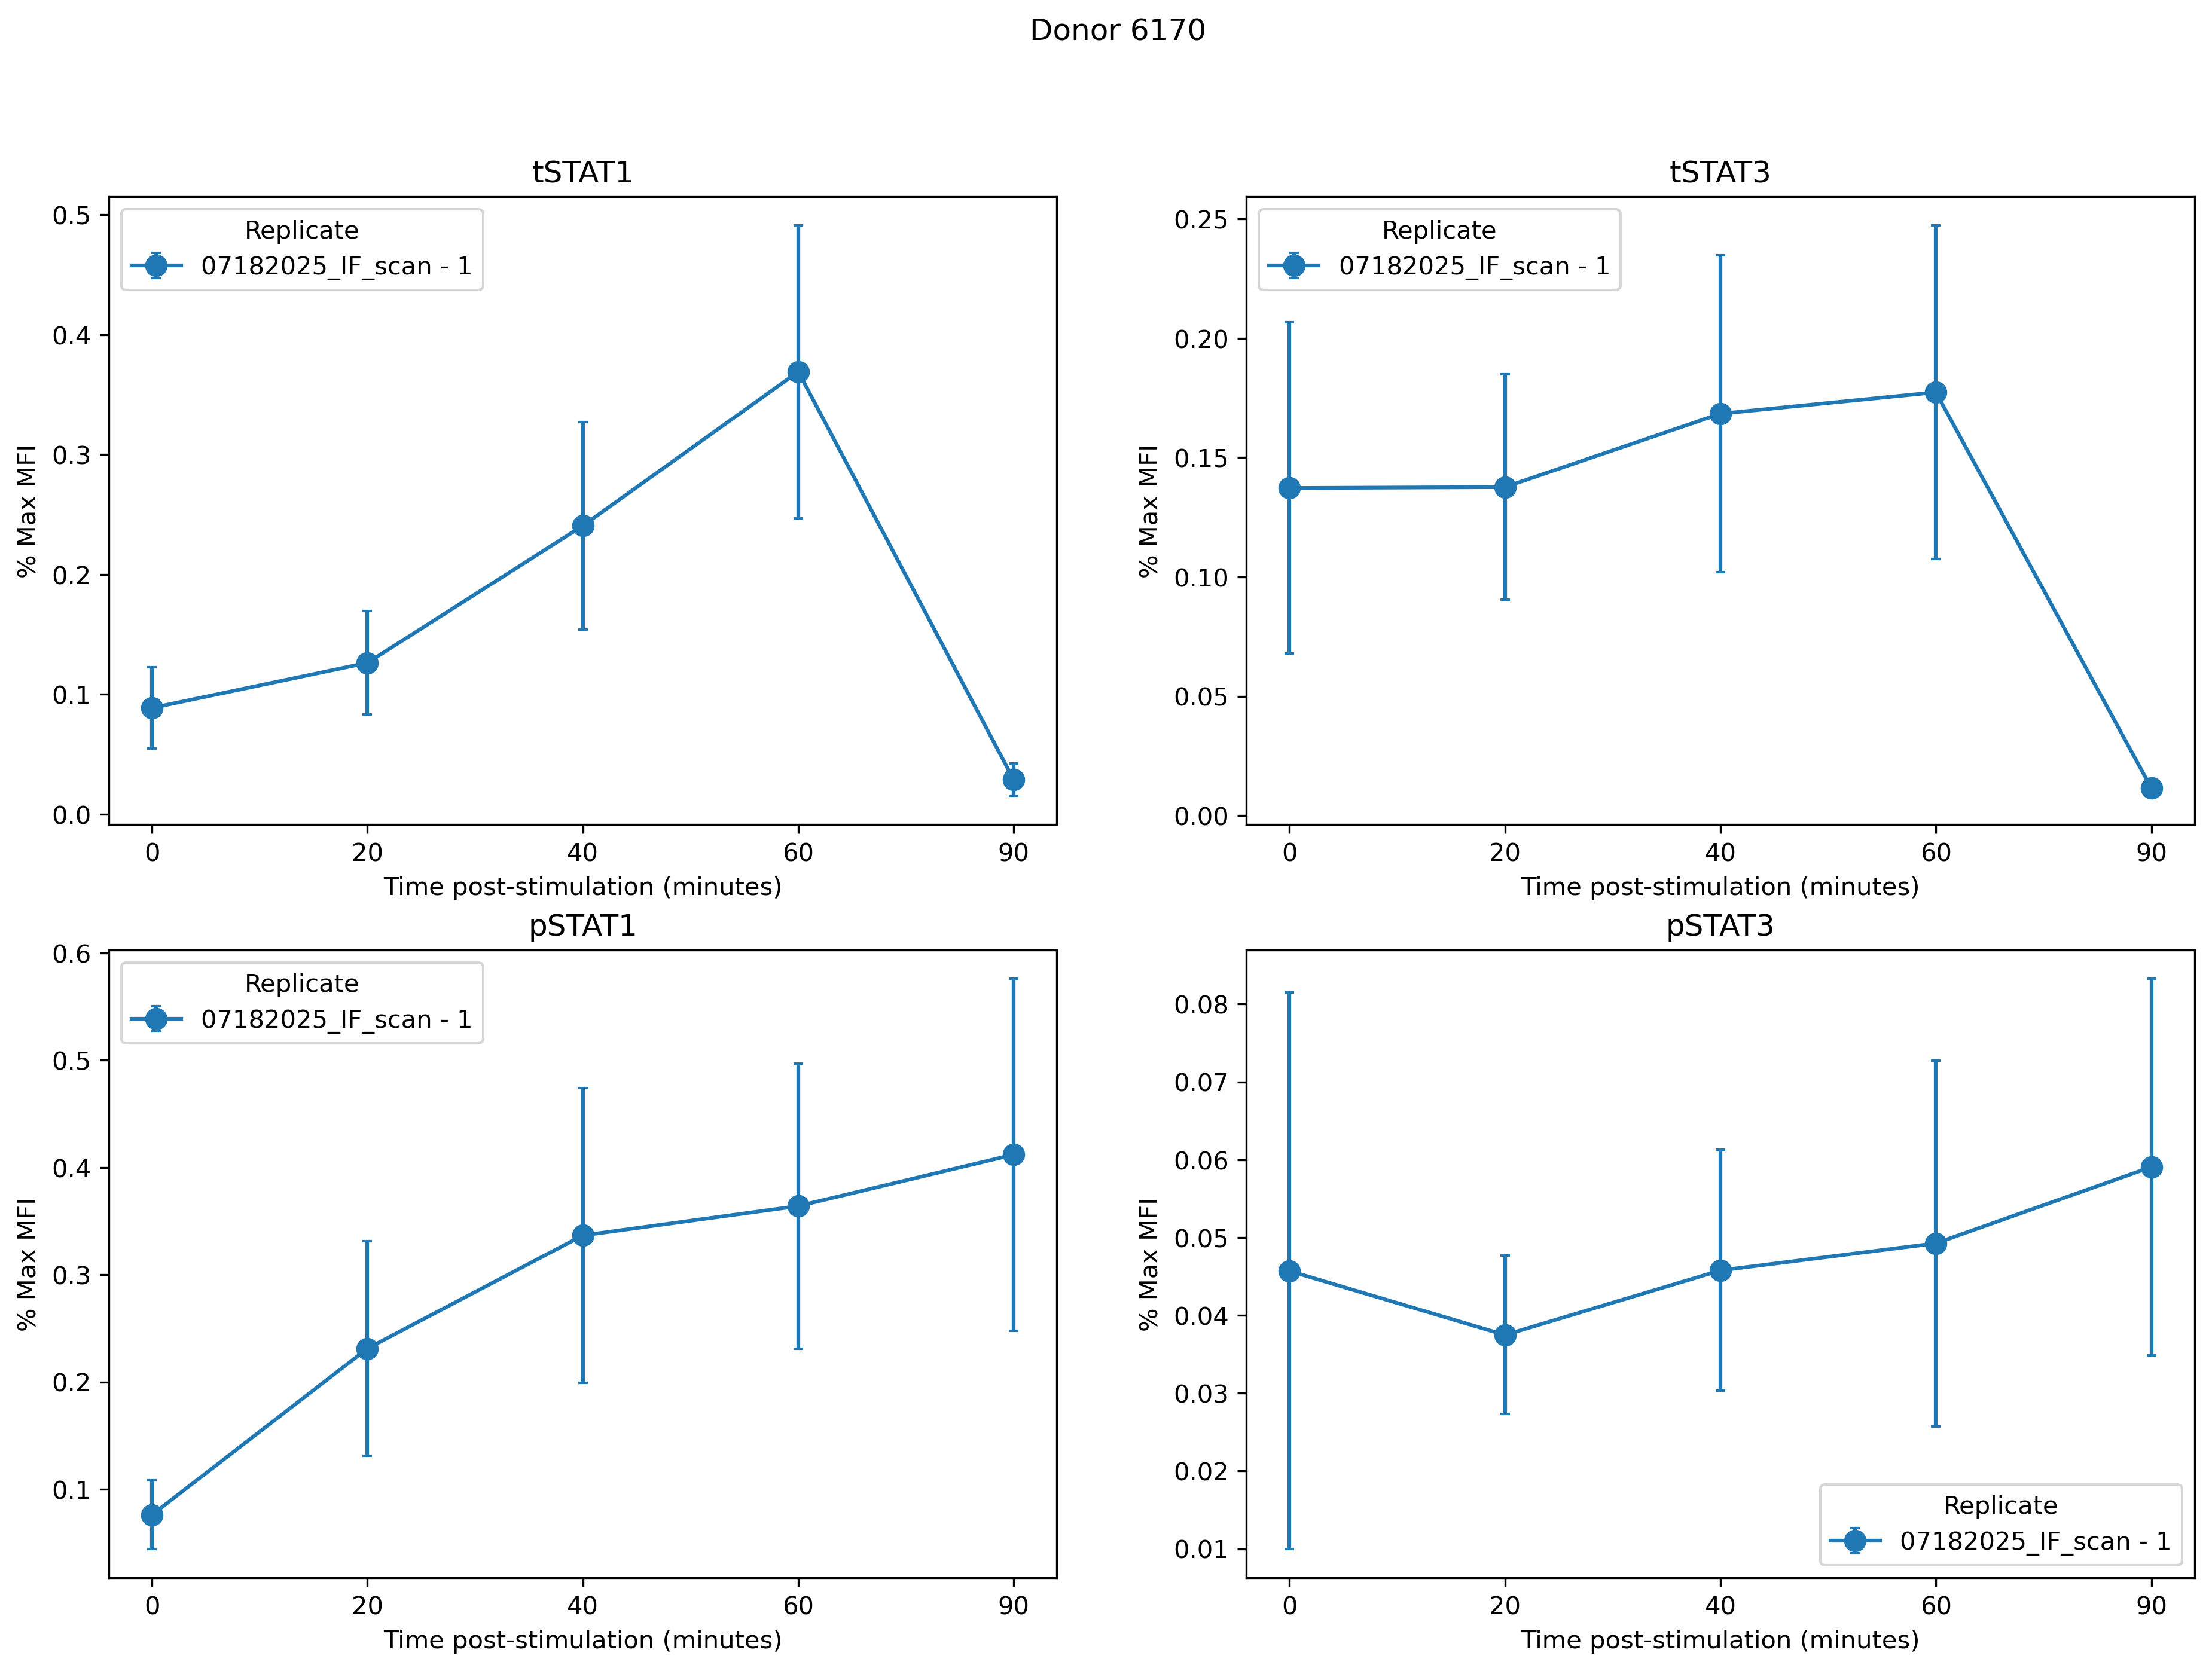

In [ ]:
all_ids = np.unique(np.array([config_dict[dir].get_unique_patient_ids() for dir in all_dirs]).flatten())

id_to_fig = dict([id, plt.subplots(2,2, figsize=(15,10), dpi=300)] for id in all_ids);
ms = 8 # markersize

for id in all_ids:
	fig, ax = id_to_fig[id]
	fig.suptitle(f"Donor {id}")
	for dir in all_dirs:
		plate = config_dict[dir]
		
		# Get tSTAT data first 
		df = plate.stat_df[(plate.stat_df["Donor"] == id) & (plate.stat_df["STAT"] == "tSTAT")] # TO DO: add case where included plate does NOT include specific donor
		
		stat1_ax = ax[0][0]
		stat3_ax = ax[0][1]
		for rep in df["Replicate"].unique():
			select_df = df.loc[df["Replicate"]== rep]
			stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
			
			stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
		stat1_ax.set_ylabel("% Max MFI")
		stat1_ax.set_xlabel("Time post-stimulation (minutes)")
		stat1_ax.legend(title="Replicate")
		stat1_ax.set_title("tSTAT1")
		stat3_ax.set_ylabel("% Max MFI")
		stat3_ax.set_xlabel("Time post-stimulation (minutes)")
		stat3_ax.legend(title="Replicate")
		stat3_ax.set_title("tSTAT3")
  
		# Get pSTAT data first 
		df = plate.stat_df[(plate.stat_df["Donor"] == id) & (plate.stat_df["STAT"] == "pSTAT")] # TO DO: add case where included plate does NOT include specific donor
		
		stat1_ax = ax[1][0]
		stat3_ax = ax[1][1]
		for rep in df["Replicate"].unique():
			select_df = df.loc[df["Replicate"]== rep]
			stat1_ax.errorbar(x=select_df["Time"], y=select_df["STAT1 Mean"], yerr=select_df["STAT1 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
			
			stat3_ax.errorbar(x=select_df["Time"], y=select_df["STAT3 Mean"], yerr=select_df["STAT3 STD"],
						marker=plate.replicate_to_marker[rep], ms=ms,
						ls="-", label=f"{dir} - {rep}", capsize=2)
		stat1_ax.set_ylabel("% Max MFI")
		stat1_ax.set_xlabel("Time post-stimulation (minutes)")
		stat1_ax.legend(title="Replicate")
		stat1_ax.set_title("pSTAT1")
		stat3_ax.set_ylabel("% Max MFI")
		stat3_ax.set_xlabel("Time post-stimulation (minutes)")
		stat3_ax.legend(title="Replicate")
		stat3_ax.set_title("pSTAT3")

In [ ]:
from scipy import stats

for dir in all_dirs:
	plate_config = config_dict[dir]
	 
	def pairwise_lfcs(control, test):
		print("IN THE FUNCTION")
		results = []
		for a, b in itertools.product(test, control):
			#print(a,b)
			if b == 0 or a == 0:
				log2fc = np.nan  # avoid division by zero
			else:
				log2fc = np.log2(a / b)
			results.append(log2fc)
		print(results)
		return results

	lfc_df = pd.DataFrame()
	def calculate_fold_changes(plate):
		data = plate.data
		for row in data["Row"].unique():
			for i, control_col in enumerate(plate.control_columns):
				control_well_data = data[(data["Row"] == row) & (data["Column"] == f"{control_col:02d}")]
				
				ctrl_stat1 = control_well_data['CircTotalIntenCh2']
				ctrl_stat3 = control_well_data['CircTotalIntenCh3']
				ctrl_normal_stat, ctrl_pval = stats.shapiro(ctrl_stat1)
				plt.figure()
				plt.title(f"{plate.column_to_stain[control_col]}1 - Row {row} - Donor {plate.row_to_patient[row]}")
				plt.hist(ctrl_stat1, bins=30, label=f"Control ({ctrl_normal_stat:.2f})", alpha=0.5)
				plt.xlabel("Fluorescence Intensity")
				plt.ylabel("Count")
				
				for test_col in plate.test_columns[i]:
					test_data = data[(data["Row"] == row) & (data["Column"] == f"{test_col:02d}")]		
					test_stat1 = test_data['CircTotalIntenCh2']
					test_stat3 = test_data['CircTotalIntenCh3']
		 
					test_normal_stat, test_pval = stats.shapiro(test_stat1)			
					label = f"{plate.column_to_t_pts[test_col]} min ({test_normal_stat:.2f})"
					plt.hist(test_stat1, bins=30, label=label, alpha=0.5)

					#stat1_lfc = pairwise_lfcs(control=control_well_data["CircTotalIntenCh2"],
					#					test=test_data["CircTotalIntenCh2"])
					#stat3_lfc = pairwise_lfcs(control=control_well_data["CircTotalIntenCh3"],
					#					test=test_data["CircTotalIntenCh3"])
					#print("HERE IS STAT! LFCS:", stat1_lfc)
					#break
				plt.legend()
				#break
			#break

	calculate_fold_changes(plate=plate_config)